# Summary

This notebook solves for evolution of an initial concave profile into (for a ramp-flat process model) a big, possibly permanent knickpoint.

This set of solutions only handles ray propagation from a set of seed points along the initial profile; it does not handle consequent profile evolution driven by subsequent change at the left-edge boundary condition.

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['InitialProfile_tanbeta_ramp_concaveup_eta1p0_kh1p5']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
from gme.ode_knickpoints import InitialProfileSolution
from gme.plot import TimeDependentPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme

# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Knickpoints')
pr_path, pr_filenames

Fetching working path from environment variable GME_WORKING_PATH = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Knickpoints',
 ['InitialProfile_tanbeta_ramp_convexup_eta1p0_kh1p5'])

In [2]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'InitialProfileSolutions',
    'short_name': 'ips',
    'subtitle': '',
    'title': 'Initial profile solution: ramp, convex-up, tan(beta) xi model',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'tan',
    'chi': 30,
    'do_geodesic': False,
    'eta': 1,
    'h_0': 1/2,
    'ibc_type': 'convex-up',
    'kappa_h': 3/2,
    't_xiv0_list': None,
    'varphi_0': 10,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.02,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 300,
    'spline_order': 3,
    't_isochrone_max': 0.008,
    'tolerance': 1e-05}
{   'ang_x_limits': None,
    'ang_

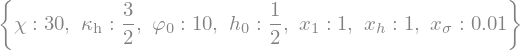

In [3]:
sub = {x_1: pr.model.x_1, 
       chi: pr.model.chi, 
       varphi_0: pr.model.varphi_0,
       kappa_h: pr.model.kappa_h,
       h_0: pr.model.h_0,
       x_sigma: pr.model.x_sigma,
       x_h: pr.model.x_h}
sub

# Equations

Generate the GME equation set using Sympy, after specifying in the erosion model the gradient exponent $\eta$, the process transition model ("ramp" or "rampflat"), and the shape of the initial profile ("concave" or "convex").

In [4]:
# pr.model.do_geodesic = True
# pr.solve.do_geodesic = True

In [5]:
gmeq = Equations( eta=pr.model.eta, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  parameters=sub,
                  do_geodesic=pr.model.do_geodesic )

# Integration

Integrate Hamilton's equations from an initial profile. Various ODE integration methods can be used here, but Radau quadrature turns out to be the most accurate. SciPy's "LSODA" (Adams/BDF method with automatic stiffness detection and switching) fails.

Create an instance of the ODE solution object.

In [6]:
# t_reduce = 2
# pr.solve.t_end = 0.012/t_reduce
# pr.resolve.t_isochrone_max = 0.012/t_reduce
# pr.solve.ip_res = 1
# pr.plot.ray_subsetting = 1

In [7]:
# # pr.solve.choice = 'Hamilton'
# pr.solve.choice = 'geodesic'
# pr.solve.method[pr.solve.choice] = 'LSODA'

In [8]:
# pr.solve.method[pr.solve.choice] = 'RK45'

In [9]:
# pr.solve.model_choice = 'Hamilton'
gmes = InitialProfileSolution( gmeq, parameters=sub, 
                               choice=pr.solve.choice,
                               method=pr.solve.method[pr.solve.choice],
                               n_rays=pr.solve.ip_res,
                               t_end=pr.solve.t_end, 
                               n_t=pr.solve.ray_n_t, t_distribn=pr.solve.t_distribn,
                               verbose=pr.job.verbose )

Solve Hamilton's ODEs using DOP853 method of integration


Specify the set of ODEs and integrate them.

In [10]:
gmes.solve()

0% Initial conditions 0: [0.0, 0.0, 0.002483913530132739, -0.002997746658672672]
Initial conditions 1: [0.01, 0.008285314058135257, 0.0025084160041715345, -0.003027999018384796]
1% Initial conditions 2: [0.02, 0.016566901122579566, 0.0025338656717804136, -0.0030607851717167206]
2% Initial conditions 3: [0.03, 0.024841040902700576, 0.0025602897992468903, -0.0030961837717987145]
3% Initial conditions 4: [0.04, 0.033104026488381316, 0.002587716040842064, -0.0031342785849415938]
4% Initial conditions 5: [0.05, 0.041352170976441054, 0.002616172459341125, -0.003175158748559779]
5% Initial conditions 6: [0.06, 0.04958181402091973, 0.0026456875481884958, -0.0032189190441843235]
6% Initial conditions 7: [0.07, 0.05778932828262209, 0.0026762902554862684, -0.0032656601866901036]
7% Initial conditions 8: [0.08, 0.06597112575397124, 0.0027080100100155065, -0.003315489130964637]
8% Initial conditions 9: [0.09, 0.07412366393602758, 0.0027408767495329216, -0.003368519397359833]
9% Initial conditions 1

In [11]:
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes.solns[0].message, gmes.solns[0].success, gmes.solns[0].status,
              gmes.solns[0].t[-1], gmes.solns[0].y[0][-1]) )

Message: Required step size is less than spacing between numbers.
Success? False
Status: -1
t_final: 0.008624222222222224
rx_final: 1.0333327710146871


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [12]:
gmes.postprocessing()

In [13]:
# pr.resolve.t_isochrone_max = 0.01

In [14]:
gmes.resolve_isochrones( t_isochrone_max=pr.resolve.t_isochrone_max, 
                         tolerance=pr.resolve.tolerance, 
                         n_isochrones=pr.resolve.n_isochrones,
                         do_eliminate_caustics=pr.resolve.do_eliminate_caustics )

# Plots

Visualize overlapping rays and merge to show actual profile evolution.

In [15]:
gr = TimeDependentPlots()

In [16]:
prefix = ('_').join([pr.job.short_name, 
                     gmeq.beta_type+'beta', gmeq.varphi_type.replace('-',''),
                     gmeq.ibc_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix = (suffix if pr.model.varphi_type=='ramp' 
                  else suffix+'_xh{:1.1f}'.format(gmes.parameters[x_h])).replace('.','p')
suffix = suffix+'_kh{:1.1f}'.format(float(gmes.parameters[kappa_h])).replace('.','p')

job_name = prefix+suffix
job_name

'ips_tanbeta_ramp_convexup_eta1p0_kh1p5'

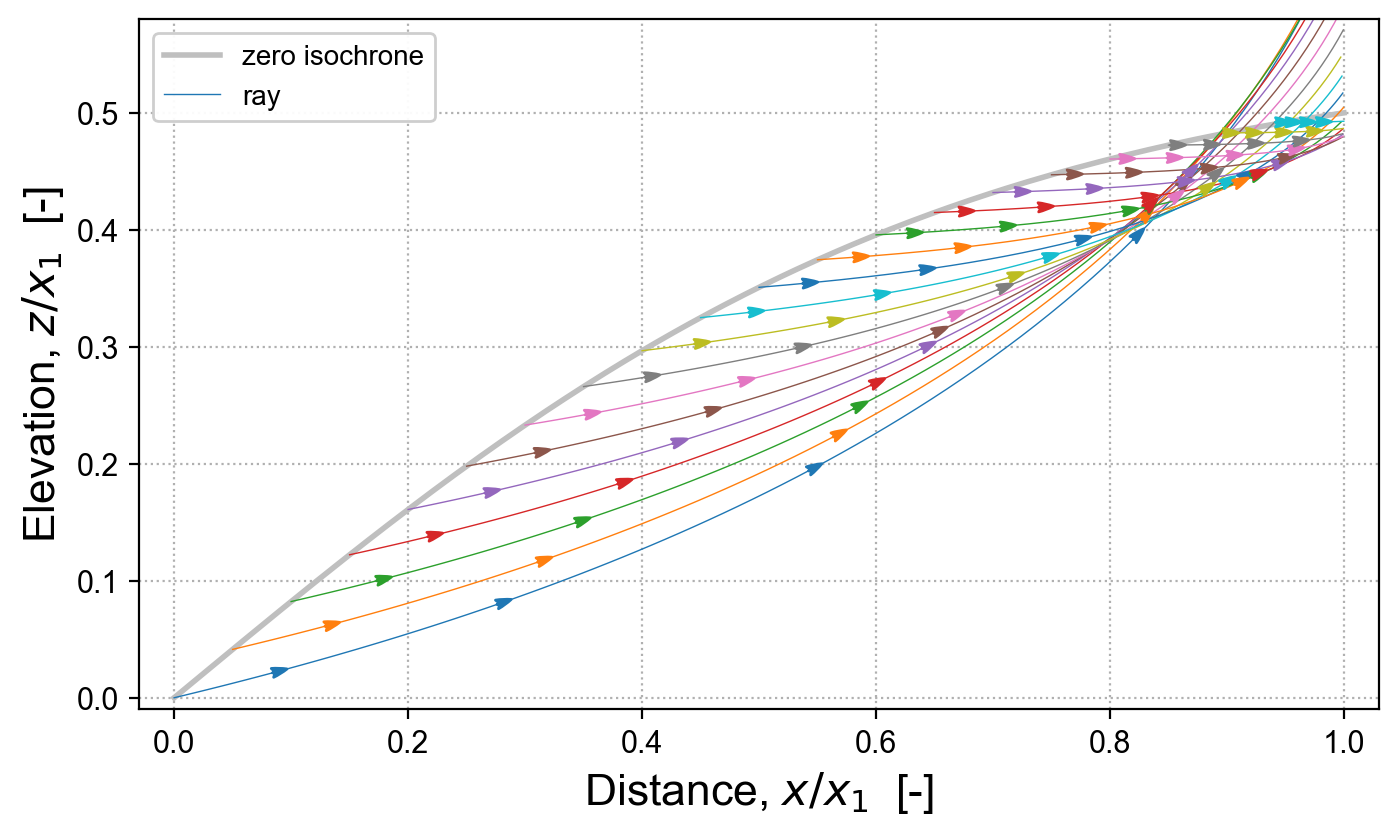

In [17]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_rays', fig_size=(8,8), 
                       do_zero_isochrone=True, do_rays=True, do_isochrones=False,
                       ray_subsetting=pr.plot.ray_subsetting,
                       do_annotate_rays=True, n_arrows=5, arrow_sf=0.5, 
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits );

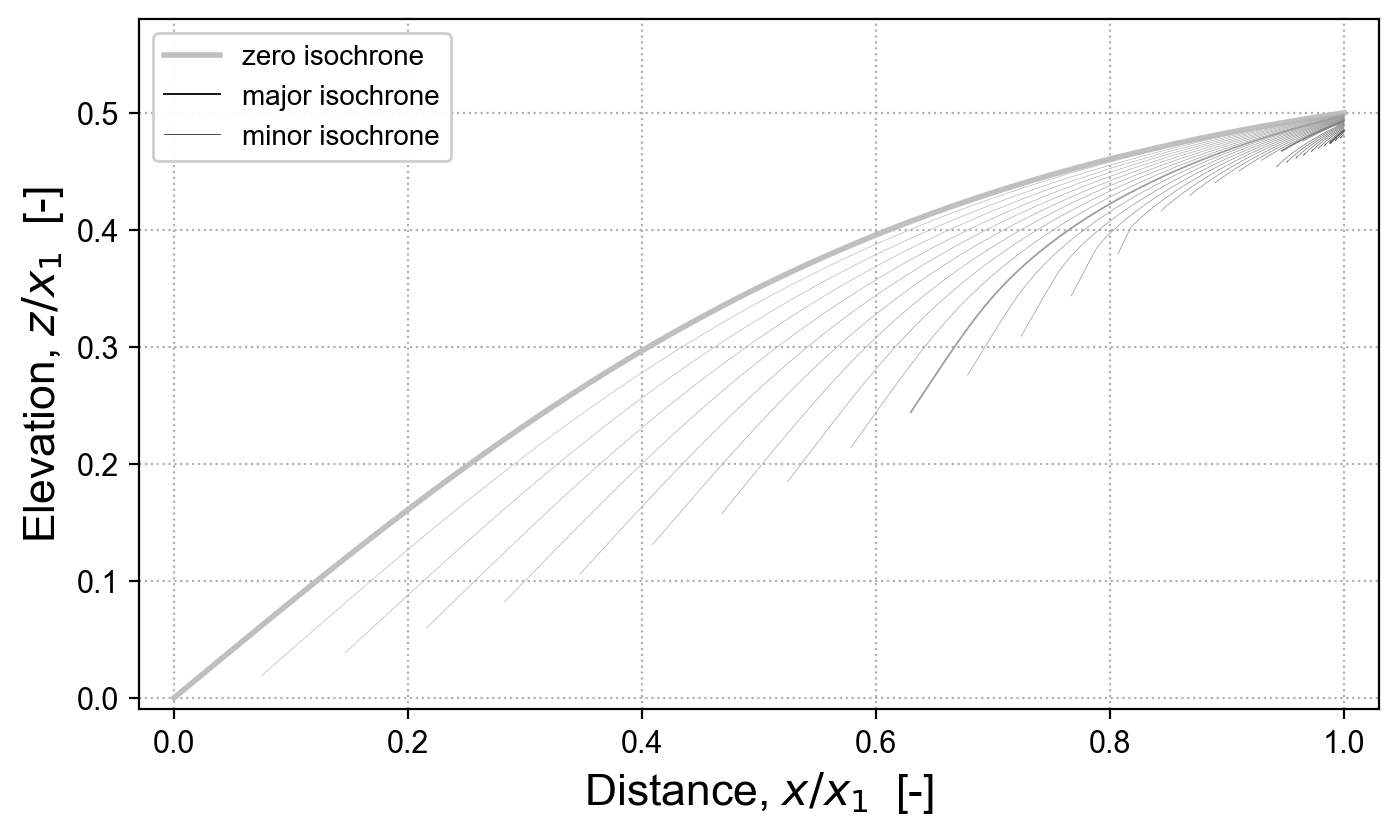

In [18]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_isochrones', fig_size=(8,8), 
                       do_zero_isochrone=True, do_rays=False,
                       ray_subsetting=pr.plot.ray_subsetting,
                       do_isochrones=True, do_annotate_cusps=False, n_arrows=5,
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits );

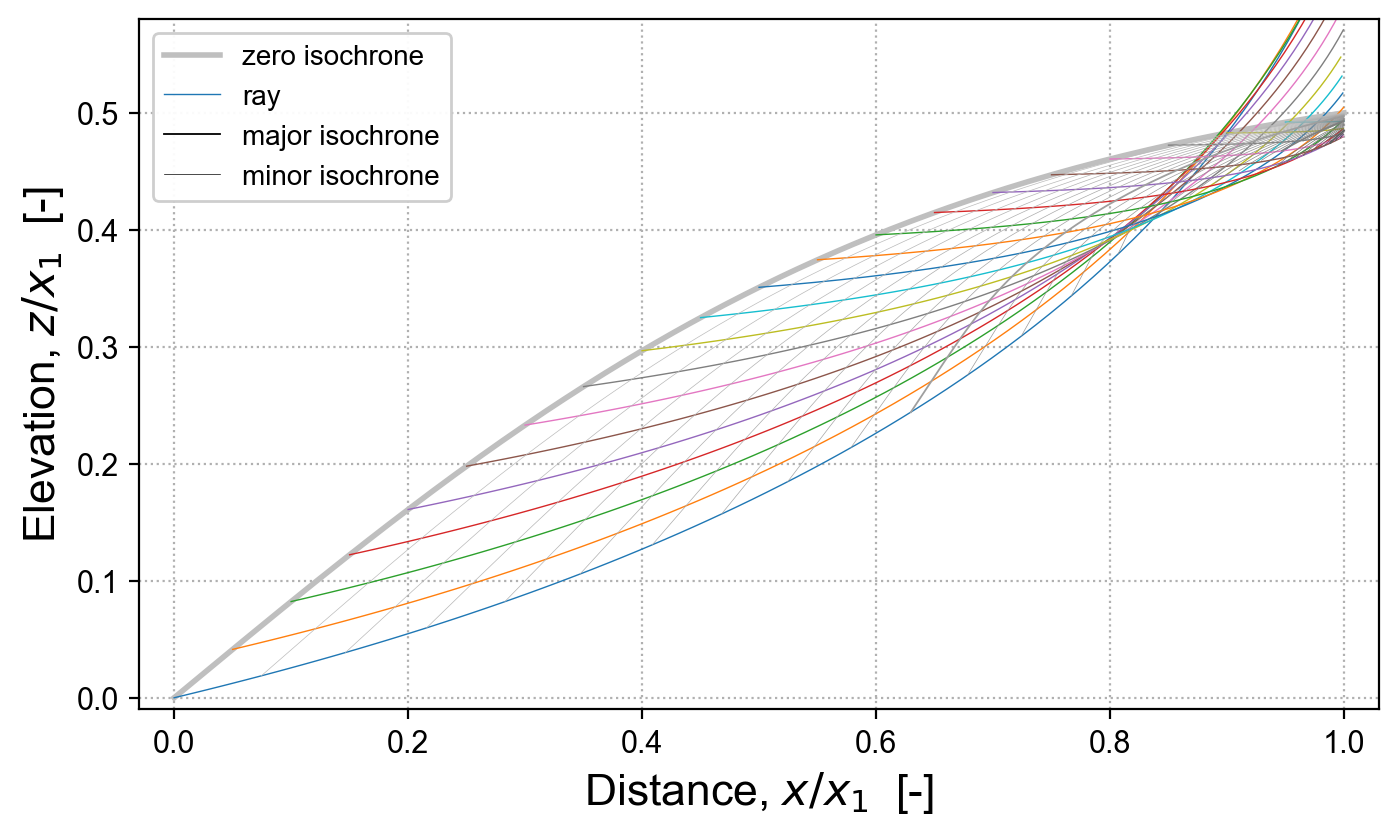

In [19]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_isochrones_rays', fig_size=(8,8), 
                       do_zero_isochrone=True, do_rays=True, do_isochrones=True, 
                       ray_subsetting=pr.plot.ray_subsetting,
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits );

# Save

In [20]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/InitialProfileSolutions"
Exported "ips_tanbeta_ramp_convexup_eta1p0_kh1p5_h_rays.png"
Exported "ips_tanbeta_ramp_convexup_eta1p0_kh1p5_h_isochrones.png"
Exported "ips_tanbeta_ramp_convexup_eta1p0_kh1p5_h_isochrones_rays.png"
